In [1]:
import torch
from torch import nn
import os
import re
from torch.utils.data import DataLoader,Dataset
import numpy as np
import collections
import nltk
from d2l import torch as d2l

In [2]:
fileDir='/home/li/ML_object/LSTM_imdb/aclImdb'
gloveDir='/home/li/ML_object/glove.6B/glove.6B.100d.txt'

In [3]:
glove=open(gloveDir).readlines()

In [4]:
words_list,words_vec=[],[]
words_dic={}

In [5]:
for line in glove:
    line=line.split(' ')
    word=line[0]
    del(line[0])
    word_vec=[float(num) for num in line]
    words_dic[word]=word_vec

In [6]:
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

In [7]:
def tokenize(content):
    content = re.sub('<.*?>', ' ', content)
#     fileters =['\/', '\(', '\)', ':', '\.', '\t', '\n', '\x97', '\x96', '#', '$', '%', '&']
#     content = re.sub('|'.join(fileters), ' ', content)
    content = re.sub(strip_special_chars, "", content)
    tokens = [i.strip().lower() for i in content.split()]
    return tokens

In [8]:
# class Vocab:
#     def __init__(self,tokens=None,min_freq=0):
#         if tokens==None:
#             tokens=[]
#         counter=count_corpus(tokens)
#         self.token_freq=sorted(counter.items(), key=lambda x: x[1],reverse=True)
#         self.unk,uniq_token=0,['<unk>']
#         uniq_token+=[token for token,freq in self.token_freq if freq>min_freq and token not in uniq_token]
#         self.idx_to_token=[]
#         self.token_to_idx={}
#         for token in uniq_token:
#             self.idx_to_token.append(token)
#             self.token_to_idx[token]=len(self.idx_to_token)-1
    
#     def __len__(self):
#         return len(self.idx_to_token)
    
#     def __getitem__(self, tokens):
#         if not isinstance(tokens, (list, tuple)):
#             return self.token_to_idx.get(tokens, self.unk)
#         return [self.__getitem__(token) for token in tokens]

#     def to_tokens(self, indices):
#         if not isinstance(indices, (list, tuple)):
#             return self.idx_to_token[indices]
#         return [self.idx_to_token[index] for index in indices]    
    
        
# def count_corpus(tokens):
#     if isinstance(tokens[0],list):
#         tokens=[token for line in tokens for token in line]
#     return collections.Counter(tokens)

In [9]:
def embedding(tokens):
    if not isinstance(tokens,(list,tuple)):
        if words_dic.get(tokens)==None:
            return [0.0]*100
        return words_dic.get(tokens)
    return [embedding(token) for token in tokens]

In [10]:
class IMDBData(Dataset):
    def __init__(self,train=True):
        if train:
            data_path=os.path.join(fileDir,"train")
        else:
            data_path=os.path.join(fileDir,"test")
        allPath=[os.path.join(data_path,"neg"),os.path.join(data_path,"pos")]
        self.data_path=[]
        for path in allPath:
            pathName=os.listdir(path)
            path_list=[os.path.join(path,name) for name in pathName]
            self.data_path.extend(path_list)         
        
            
    def __getitem__(self,index):
        path=self.data_path[index]
        label_str=path.split('/')[-2]
        label=0 if label_str=='neg' else 1
        content=open(path).read()
        token=tokenize(content)
        return token,label
        
    def __len__(self):
        return len(self.data_path)
    

In [11]:
trainset=IMDBData()

In [12]:
# allToken=[]
# for path in trainset.data_path:
#     content=open(path).read()
#     token=tokenize(content)
#     allToken.extend(token)
# vocab=Vocab(allToken)

In [13]:
print(trainset.__len__())

25000


In [14]:
# test=allToken[:10]
# print(test)
# test_w2v=embedding(test)
# print(len(test_w2v))

In [15]:
max_len=200

In [74]:
def collate_fn(batch,max_len=max_len):
    '得到大小为批量大小(文本个数)*文本长度*词向量维度(100)的小批量数据集'
    content, label = list(zip(*batch))
    content=list(content)
#     print(content)
#     for content_list in content:
#         print(len(content_list))
#         if len(content_list)<=max_len:
#             content_list+=['<unk>']*(max_len-len(content_list))
#         else:
#             print('2')
#             content_list=content_list[:max_len]
#             print(len(content_list))
#     for content_list in content:
#         print(len(content_list))
#     ####
#     content=vocab[content]
#     ####
#     print("len: ",len(content[0]))
    content=embedding(content)
    b = np.zeros([len(content),max_len,100])
    for i,j in enumerate(content):
        cnt=0;
#         for w in j:
#             cnt+=1
#             print(w)
#             print(cnt)
#         print("length: ",len(j),len(j[0]))
        length=max_len if len(j)> max_len else len(j)
#         print(length)
#         print((b[i][0:length]),(j[0:length] ))
#         print("size:")
        temp=np.array(j,dtype=object)
        cnt=0
#         for n in temp:
#             cnt+=1
#             print(cnt)
#             print(n)
#         print(temp[0])
        
#         print(b[i].shape,temp.shape)
#         print(temp[0:100])
#         for w in j:
#             if(len(w)!=100):
#                 print("fuck")
        for idx in range(length):
            b[i][idx]=temp[idx]
#         print(b[i])
#         b[i][0:length] = temp[0:length] 
#     print("b: ")
#     print(b.shape)
    b=b.transpose(1,0,2)
    content=torch.FloatTensor(b)
#     print(content)
    labels=torch.FloatTensor(label)
    return content, labels


In [75]:
train_iter=DataLoader(trainset,batch_size=100,shuffle=True,collate_fn=collate_fn)
i=0
for (X,y) in train_iter:
    print(X.shape)
    print(y.shape)
    if i==0:
        break
    i+=1
#文本预处理完成，得到神经网络可用的数据集。主要工作：分词(tokenize函数)，自定义数据集类(IMDBData)，将单词转为词向量(embedding)
#自定义collate_fn函数，默认的会zip()，造成错误

torch.Size([200, 100, 100])
torch.Size([100])


In [76]:
##构建lstm模型
#初始化模型参数

In [77]:
#先用简洁方法，即调用pytorch自带的API接口实现

In [100]:
lstm_layer=nn.LSTM(100,64,num_layers=1)

In [122]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layers,outputs,**kwargs):
        super(RNNModel,self).__init__(**kwargs)
        self.rnn=rnn_layers
        self.outputs=outputs
        self.num_hiddens=self.rnn.hidden_size
        self.linear=nn.Linear(self.num_hiddens,self.outputs)
        
    def forward(self,X,state):
        X=X.to(torch.float32)
        Y,state=self.rnn(X,state)
        print(Y.shape)
        print("state: ",state[0].shape)
        return Y,state
        
    def begin_state(self,device,batch_size=1):
        return(torch.zeros((self.rnn.num_layers,batch_size,self.num_hiddens),device=device),
              torch.zeros((self.rnn.num_layers,batch_size,self.num_hiddens),device=device),)


In [123]:
device=d2l.try_gpu()
print(device)
net=RNNModel(lstm_layer,2)

cuda:0


In [124]:
net=net.to(device)

In [125]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, y in train_iter:
        print("X_shape: ",X.shape)
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[1], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_()
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
#         y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        print("X: ",X.shape)
        print("y ",y.shape)
        y_hat, state = net(X, state)
        print("y_hat: ",y_hat.shape)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了`mean`函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [126]:
def train_ch8(net, train_iter, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
#     predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
#             print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')

X_shape:  torch.Size([200, 100, 100])
X:  torch.Size([200, 100, 100])
y  torch.Size([100])
torch.Size([200, 100, 64])
state:  torch.Size([1, 100, 64])
y_hat:  torch.Size([200, 100, 64])


ValueError: Expected input batch_size (200) to match target batch_size (100).

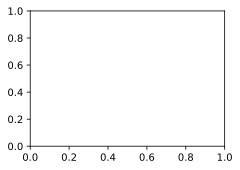

In [127]:
num_epochs,lr=500,1
train_ch8(net,train_iter,lr,num_epochs,device)